In [1]:
# Importing necessary libraries
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
import scipy

In [2]:
import tensorflow_datasets as tfds

In [3]:
import gc
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

print(tf.__version__)

Number of replicas: 1
2.15.0


In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMAGE_SIZE = [180, 180]
EPOCHS = 20

In [5]:
# Downloading the malaria dataset using TensorFlow datasets
data, info = tfds.load('malaria', split='train',with_info=True,shuffle_files=True)

DATA EXPLORATION

The Malaria dataset is contains a total of 27,558 cell images with equal instances of parasitized and uninfected cells from the thin blood smear slide images of segmented cells. The original data source is from NIH as can be seen from the link from the data info below.

In [6]:
# Accessing information about the dataset
print(info)

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir='/root/tensorflow_datasets/malaria/1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin blood smear im

In [7]:
#showing the different classes of the dataset;'parasitized' and 'uninfected'
print("Num classes: " + str(info.features['label'].num_classes))
print("Class names: " + str(info.features['label'].names))

Num classes: 2
Class names: ['parasitized', 'uninfected']


In [8]:
class_names = info.features['label'].names
print(f"Class names: {class_names}")


Class names: ['parasitized', 'uninfected']


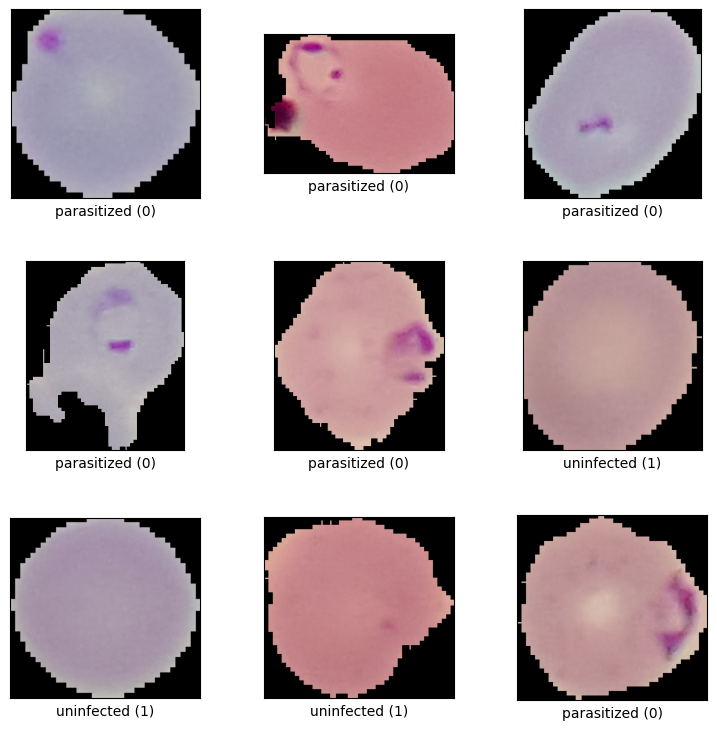

In [9]:
#vizualize the data
vis = tfds.visualization.show_examples(data, info)

converting images and labels into numpy arrays

In [10]:
#initializing empty lists to store images and labels
train_images = []
train_labels = []

# Iterating over the dataset to extract images and labels
for example in data:
    # Convert TensorFlow tensors to NumPy arrays and append to the lists
    train_images.append(example['image'].numpy())
    train_labels.append(example['label'].numpy())

In [11]:
print("Image:")
print(train_images[0])
print("Label: " + str(train_labels[0]))

Image:
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
Label: 1


The images do not have the same size .They are also in a three channel matrix.Let#s evaluate the dimensions.

In [12]:
# Clearing some RAM so as to not run out of resources

del train_images
del train_labels
del data
del info
del vis
gc.collect()

0

MODEL BUILDING

In [13]:
BATCH_SIZE = 32
IMAGE_SIZE = [200, 200]

train_ds, val_ds, test_ds = tfds.load('malaria',
                                      split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
                                      shuffle_files=True, as_supervised=True)

In [14]:
#checking how many images are in each dataset
num_train_images = tf.data.experimental.cardinality(train_ds).numpy()
print("Num training images: " + str(num_train_images))

num_val_images= tf.data.experimental.cardinality(val_ds).numpy()
print("Num validating images: " + str(num_val_images))

num_test_images = tf.data.experimental.cardinality(test_ds).numpy()
print("Num testing images: " + str(num_test_images))

Num training images: 22046
Num validating images: 2756
Num testing images: 2756


In [15]:
#checking the shape of our images
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (151, 115, 3)
Label:  1


DATA PREPROCESSING

In [16]:
# Cache the datasets to improve performance
train_ds = train_ds.cache()
val_ds = val_ds.cache()
test_ds = test_ds.cache()

In [17]:
#resizing the images to (200,200) and normalize the pixel values

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, IMAGE_SIZE) / 255.0, y)).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (tf.image.resize(x, IMAGE_SIZE) / 255.0, y)).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, IMAGE_SIZE) / 255.0, y)).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

In [18]:
# Checking the shape of the data
print(train_ds.element_spec[0].shape)

(None, 200, 200, 3)


DATA AUGMENTATION

In [19]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [20]:
# Checking the shape of the images after augmentation
for image, label in train_ds.take(1):
    print("Image shape after augmentation: ", image.numpy().shape)
    print("Label: ", label.numpy())


Image shape after augmentation:  (32, 200, 200, 3)
Label:  [0 0 0 0 0 1 1 1 0 1 0 0 1 0 1 1 1 1 0 1 1 0 1 1 0 0 1 1 1 1 0 0]


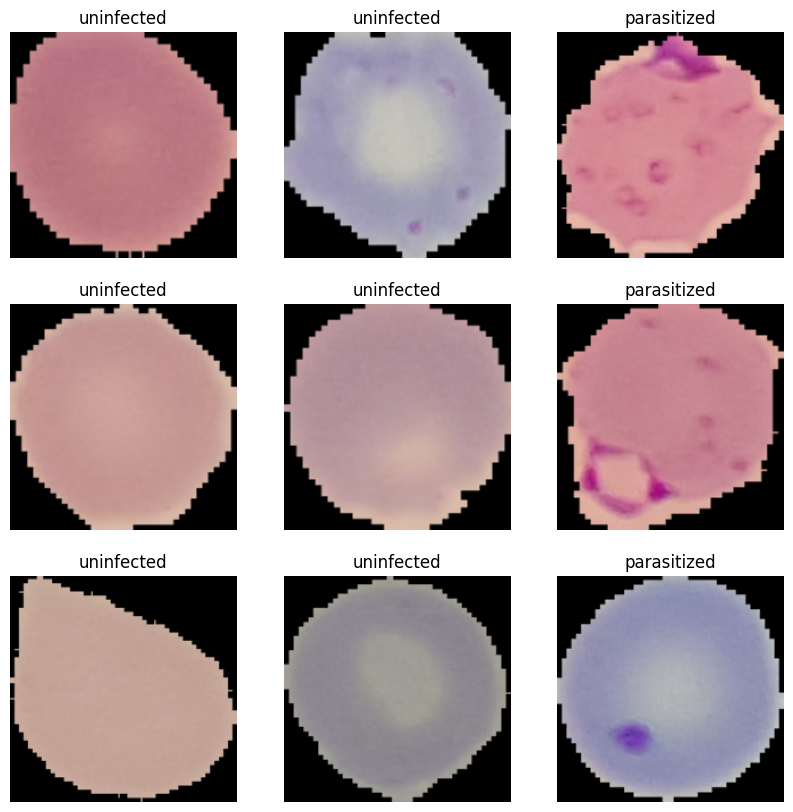

In [21]:
#vizualizing the augmented images

import matplotlib.pyplot as plt

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(class_names[labels[i]])
        plt.axis("off")

    plt.show()

BUILDING THE MODEL USING CNN(CONVOLUTIONAL NEURAL NETWORK)

In [22]:
#Defining the model
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE)
n_classes = 2
model = models.Sequential([
    data_augmentation,
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    #After each (convolution+ReLU) comes Pooling and finally Flattening to an Array of neurons.
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    #Last Layer has 3 Neurons
    #Softmax activation function will normalize the probability of our classes
    layers.Dense(n_classes, activation = 'softmax'),
])


MODEL COMPILING

In [23]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [24]:
#training the model
history = model.fit(
    train_ds,
    epochs = 20,
    batch_size = 32,
    verbose = 1,
    #Validation data is used in each Epoch to track accuracy during training
    validation_data = val_ds
)

Epoch 1/20
689/689 [==============================] - 40s 48ms/step - loss: 0.2421 - accuracy: 0.9137 - val_loss: 0.1562 - val_accuracy: 0.9536
Epoch 2/20
689/689 [==============================] - 27s 39ms/step - loss: 0.1623 - accuracy: 0.9513 - val_loss: 0.1465 - val_accuracy: 0.9575
Epoch 3/20
689/689 [==============================] - 27s 39ms/step - loss: 0.1529 - accuracy: 0.9526 - val_loss: 0.1380 - val_accuracy: 0.9557
Epoch 4/20
689/689 [==============================] - 26s 38ms/step - loss: 0.1502 - accuracy: 0.9546 - val_loss: 0.1382 - val_accuracy: 0.9575
Epoch 5/20
689/689 [==============================] - 26s 37ms/step - loss: 0.1426 - accuracy: 0.9551 - val_loss: 0.1303 - val_accuracy: 0.9568
Epoch 6/20
689/689 [==============================] - 26s 37ms/step - loss: 0.1433 - accuracy: 0.9547 - val_loss: 0.1347 - val_accuracy: 0.9586
Epoch 7/20
689/689 [==============================] - 27s 39ms/step - loss: 0.1385 - accuracy: 0.9557 - val_loss: 0.1329 - val_accuracy:

In [25]:
#checking how well the model is performing by trying it out on a test dataset,so that it is not biased
scores=model.evaluate(test_ds)

87/87 [==============================] - 2s 28ms/step - loss: 0.1285 - accuracy: 0.9612


In [26]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 99, 99, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 48, 48, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 64)       

In [27]:
history
history.params
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [28]:
#We can then store the lists from the history dictionaryin different variables and use them to make plots.
loss = history.history['loss']
acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

Text(0.5, 1.0, 'Training and Validation Loss')

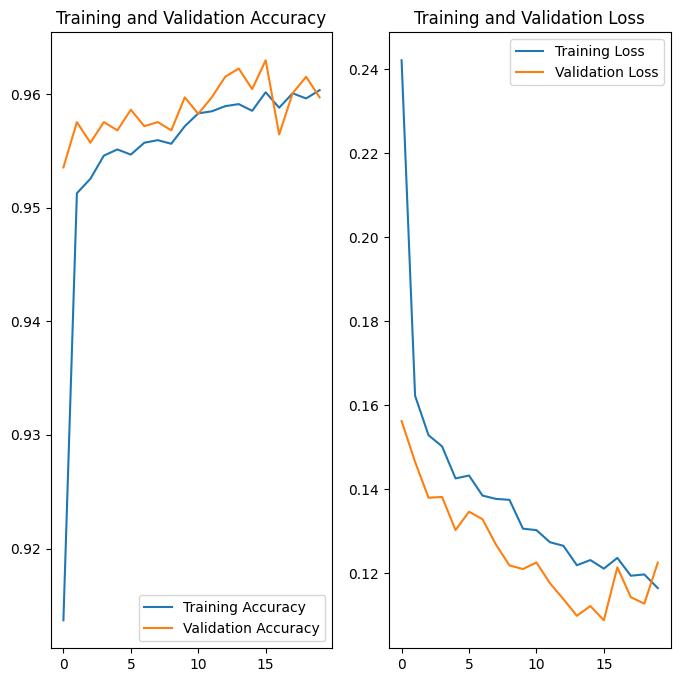

In [29]:
#The Accuracy Chart,checks accuracy of the epochs
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')
#The loss Chart,error in back propagation keeps on reducing as we proceed with our epochs
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label = 'Training Loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')

In [31]:
#Testing the model
for images_batch, labels_batch in test_ds.take(1):
    # Change the model call to match your model's input and output
    batch_prediction = model.predict(images_batch)

    # Change the output to match your model's output
    predicted_label = np.argmax(batch_prediction[0])
    actual_label = labels_batch[0].numpy()

    print("actual label:", class_names[actual_label])
    print("predicted label:", class_names[predicted_label])

    if actual_label == predicted_label:
        print("The actual label matches the predicted label.")
    else:
        print("The actual label does not match the predicted label.")



1/1 [==============================] - 0s 203ms/step
actual label: uninfected
predicted label: uninfected
The actual label matches the predicted label.


The above code shows our model is working well,the actual labels nd the predicted labels match

In [32]:
#this function will tell us the predicted class and confidence
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0)#create a batch

    predictions = model.predict(img_array)

    predicted_class = class_name[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])),2)
    return predicted_class,confidence

1/1 [==============================] - 0s 72ms/step


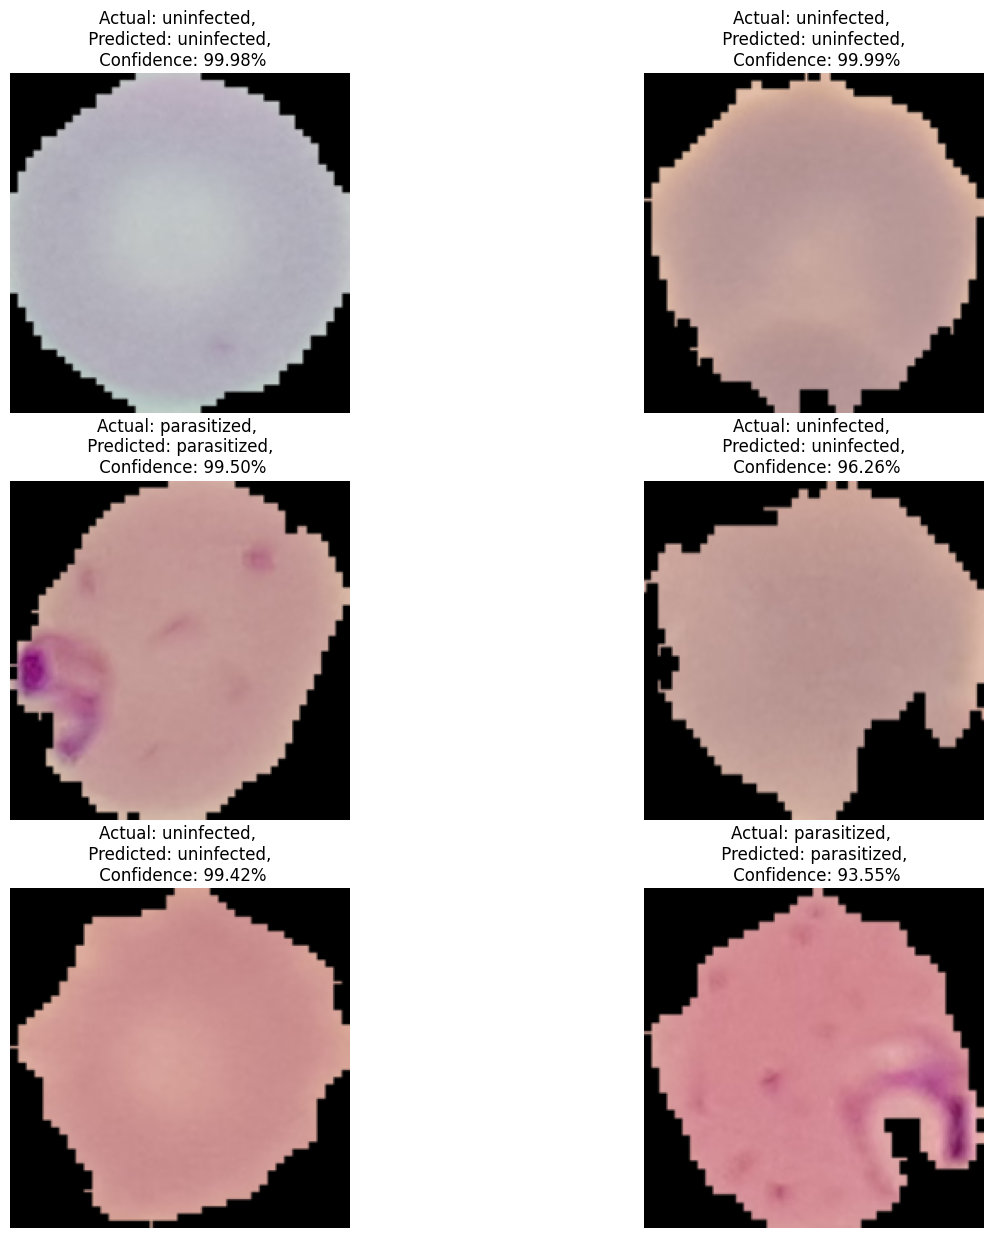

In [33]:
num_images = 6

#getting the images and labels from the test dataset
images, labels = next(iter(test_ds))
predictions = model.predict(images)

# Get the predicted labels and confidence scores
predicted_labels = np.argmax(predictions, axis=1)
confidence_scores = np.max(predictions, axis=1) * 100

# Create a figure with subplots
plt.figure(figsize=(15, 15))

# Loop through the images and display them
for i in range(num_images):
    plt.subplot(3, 2, i + 1)
    plt.imshow(images[i].numpy())
    plt.title(f"Actual: {class_names[labels[i]]}, \n Predicted: {class_names[predicted_labels[i]]}, \n Confidence: {confidence_scores[i]:.2f}%")
    plt.axis("off")

# Show the plot
plt.show()


As we can see above ,the confidence levels are high which shows our model is indeed working as we expect.

After creating the model,the model can be saved to the Drive and used to create a website or application(using backend and frontend development) that can be used by other people to predict Malaria by simply taking a picture or inserting an image on the website or application.